# XGBoost

In [ ]:
pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time  
import ast
import pytz

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import precision_recall_curve, make_scorer
from sklearn.metrics import roc_curve, auc

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

In [2]:
df = pd.read_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\encoded_w_outliers.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9804 entries, 0 to 9803
Columns: 247 entries, user_is_clicker to user_primary_category_d90_162.0
dtypes: float64(4), int64(243)
memory usage: 18.5 MB


In [4]:
X = df.drop(['target'],axis=1)
y = df['target']

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [6]:
X_train.shape

(6862, 246)

In [7]:
X_test.shape

(2942, 246)

In [8]:
#Let us load the Model Performance dataframe that we created in the previous notebook (notebook 4)
#It contains performance summary of the earlier models
performance_df = pd.read_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\performance_df.csv")

In [9]:
# Function to add model's performance to the Model Performance Dataframe
def add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value):
    new_row = {
        'Model Name': model_name,
        'Elapsed Time': elapsed_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Log Loss': log_loss_value
    }
    return performance_df.append(new_row, ignore_index=True)

# XGBoost - Basic

In [10]:
model_name = "XGBoost - Basic"

# Start the timer
start_time = time.time()

# Convert the datasets into DMatrix objects, which is an internal data structure that XGBoost uses optimized for both memory efficiency and training speed
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Let us specify basic parameters for the XGBoost model (we can try to tune them later)
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,      # the training step for each iteration
    'objective': 'binary:logistic',  # binary classification and logistic regression
    'eval_metric': 'logloss',  # evaluation metric for validation data
}

# Number of training iterations
num_round = 100

# Train the model
xgboost_basic = xgb.train(params, dtrain, num_round)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)


Elapsed Time: 0.49222779273986816


**Note**:
- Since XGBoost uses different output objects from the earlier-created models (DMatrix objects), we cannot use the same function that I used to render the model performance summary as I used in the previous notebook

In [12]:
# Predict the labels of the test set
predictions = xgboost_basic.predict(dtest)
print(predictions)

# Since we are using binary classifications, we will us 0.5 as a threshold for now.
y_pred_binary = (predictions > 0.5).astype(int)
print(y_pred_binary)

[2.0969706e-04 9.9998641e-01 9.9970132e-01 ... 9.9982965e-01 2.7255827e-01
 9.9994910e-01]
[0 1 1 ... 1 0 1]


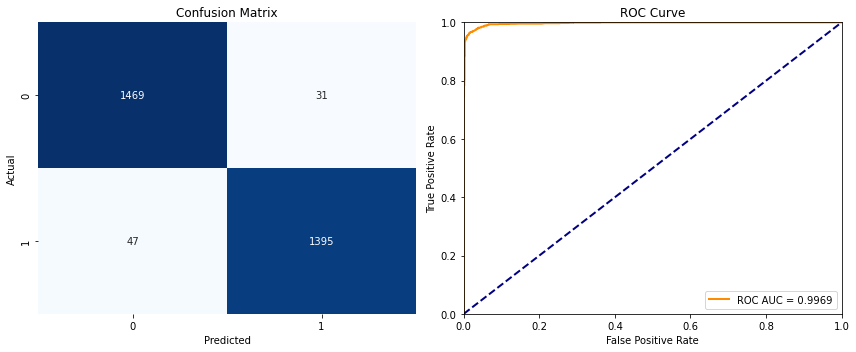

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


In [13]:
# Now let us see how the model performed

# Predict the labels of the test set
predictions = xgboost_basic.predict(dtest)

# Since we are using binary classifications, we will us 0.5 as a threshold for now.
y_pred = (predictions > 0.5).astype(int)

# Compute the confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)

y_prob = predictions

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Compute main metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc_score_value = roc_auc_score(y_test, y_prob)
log_loss_value = log_loss(y_test, y_prob)

# Update the performance DataFrame
performance_df = add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc_score_value, log_loss_value)

performance_df

**Observations**:
- Basic XGBost is laredy better than the best (optimized) basic models that I created in the previous notebooks in terms of LogLoss
- Let us see if we can optimize it.

In [14]:
model_name = "XGBoost - Optimized"

# Start the timer
start_time = time.time()

# Create the parameter grid to search
param_grid = {
    'max_depth': [3, 4, 5, 7],            # maximum depth of each tree
    'learning_rate': [0.05, 0.1], # step size shrinkage used in update to prevent overfitting
    'n_estimators': [150, 200, 250, 300, 350],    # number of trees you want to build
    'subsample': [0.6, 0.7, 0.8, 0.9],         # subsample ratio of the training instances
    'colsample_bytree': [0.4, 0.6, 0.8], #the fraction of features (randomly selected) that will be used to train each tree
}

# Create a base model
xgb_model = xgb.XGBClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# View the best parameters from the grid search
best_params = grid_search.best_params_

# Train the model using the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Elapsed Time: 246.88304018974304


In [15]:
# Lets get the best params
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters found by grid search:")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Best parameters found by grid search:
colsample_bytree: 0.4
learning_rate: 0.1
max_depth: 3
n_estimators: 300
subsample: 0.7


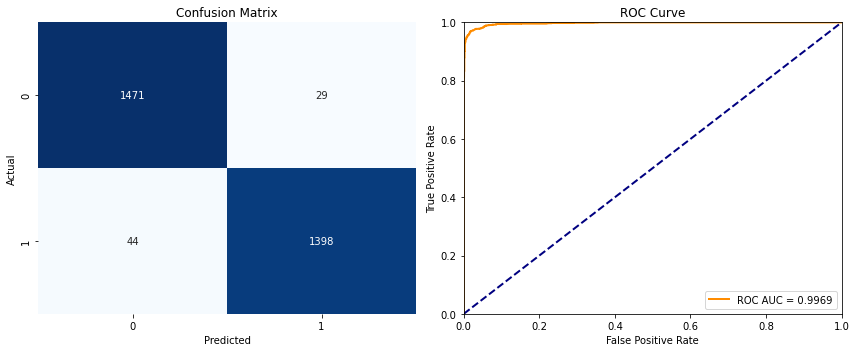

Accuracy: 0.97349
Precision: 0.97826
Recall: 0.96741
F1 Score: 0.97280
LogLoss: 0.06711
ROC AUC: 0.99690


In [17]:
# Now let us see how the model performed

# Predict the labels of the test set
predictions = best_xgb_model.predict(X_test)

# Since we are using binary classifications, we will us 0.5 as a threshold for now.
y_pred = (predictions > 0.5).astype(int)

# For LogLoss and ROC AUC, we will need the probability testimation (not binary class prediction)
y_prob = best_xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Compute main metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc_score_value = roc_auc_score(y_test, y_prob)
log_loss_value = log_loss(y_test, y_prob)

print(f'Accuracy: {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')
print(f'LogLoss: {log_loss_value:.5f}')
print(f'ROC AUC: {roc_auc:.5f}')

In [18]:
# Update the performance DataFrame
performance_df = add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value)

performance_df

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


**Observations:**
- Grid search produced a slight improvement to LogLoss
- Since XGBoost is our best model yet, let us attempt another grid searh with different params. We will try params that are closer to the winning params, but wil also experiment with few other params.

In [21]:
model_name = "XGBoost - Optimized2"

# Start the timer
start_time = time.time()

# Create the parameter grid to search
param_grid = {
    'max_depth': [3],                           # lets fix it since it worked well last time
    'learning_rate': [0.1],                     # lets fix it since it worked well last time
    'n_estimators': [275, 300, 325],       # number of trees you want to build
    'subsample': [0.65, 0.7, 0.75],              # subsample ratio of the training instances
    'colsample_bytree': [0.35, 0.4, 0.45], #the fraction of features that will be used to train each tree
    'gamma': [0.5, 1, 1.5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
}

# Create a base model
xgb_model = xgb.XGBClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# View the best parameters from the grid search
best_params = grid_search.best_params_

# Train the model using the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Elapsed Time: 914.88822722435


In [22]:
# Lets get the best params
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters found by grid search:")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Best parameters found by grid search:
colsample_bytree: 0.35
gamma: 1
learning_rate: 0.1
max_depth: 3
n_estimators: 300
reg_alpha: 0.1
reg_lambda: 1
subsample: 0.65


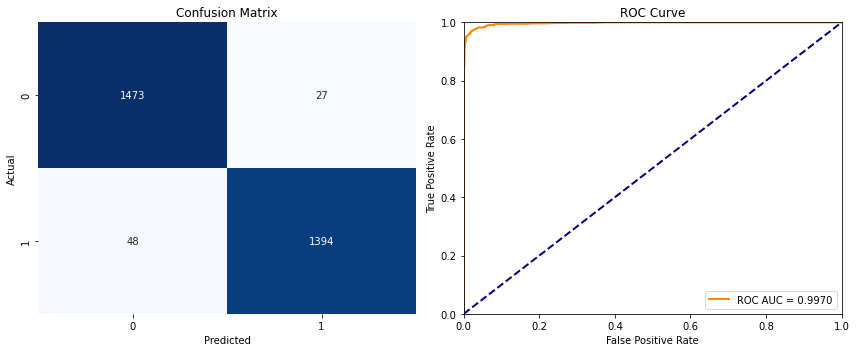

Accuracy: 0.97349
Precision: 0.97826
Recall: 0.96741
F1 Score: 0.97280
LogLoss: 0.06610
ROC AUC: 0.99699


In [24]:
# Now let us see if the new grid search produced further improvements

# Predict the labels of the test set
predictions = best_xgb_model.predict(X_test)

# Since we are using binary classifications, we will us 0.5 as a threshold for now.
y_pred = (predictions > 0.5).astype(int)

# For LogLoss and ROC AUC, we will need the probability testimation (not binary class prediction)
y_prob = best_xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots for confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot the ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Compute main metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc_score_value = roc_auc_score(y_test, y_prob)
log_loss_value = log_loss(y_test, y_prob)

print(f'Accuracy: {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')
print(f'LogLoss: {log_loss_value:.5f}')
print(f'ROC AUC: {roc_auc:.5f}')

In [25]:
# Update the performance DataFrame
performance_df = add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value)

performance_df

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


**Conclusion:**
- Through a more extensive (and very lengthy) grid search, Part 2, we found another small improvement in LogLos and other metrics. XBoost is our best-performing model yet.
- it remains to be seen if prediction/inference in real-time will be fast enough when using XGBoost in Production when deciding how much to bid on our ad requests. 


In [26]:
#Let us export the performance datafraome to .csv
performance_df.to_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\performance_df.csv", index=False)